# Example notebook to perform experiments and evaluate all endpoints

This notebook is part of the supporting information to the manuscript entitled "Conformal Prediction and 
Exchangeability in Toxicological In Vitro Datasets (title tbd)". The script was developed by Andrea Morger in the 
In Silico Toxicology and Structural Biology Group of Prof. Dr. Andrea Volkamer at the Charité Universitätsmedizin 
Berlin, in collaboration with Fredrik Svensson, Ulf Norinder and Ola Spjuth. It was last updated in September 2020.

## Content


In this notebook, it is shown how the experiments for the CPTox21 manuscript (train model and make predictions with Tox21 data, update the training and/or calibration set) are run for multiple endpoints. Furthermore the evaluation over all enpoints in the form of boxplots is provided.

The notebook consists of three main parts.

1. Preparation
    - Used Python libraries are loades
    - Paths and parameters are defined
2. Conformal prediction experiments
    - Prepare experiments
    - Run experiments
3. Evaluate conformal predictions
    - Calibration plots
    - Calculate rmsds
    - Generate boxplots
    - Line plots

### Table of contents
1. [Preparation](#preparation) <br>
    1.1. [Import libraries and modules](#import-libraries-and-modules)<br>
    1.2. [Define paths and parameters](#define-paths-parameters)<br>
2. [Conformal prediction experiments](#cp-experiments)<br>
    2.1. [Build conformal predictors](#build-cps)<br>
    2.2. [Perform experiments for all endpoints](#perform-exp)<br>
3. [Evaluate conformal predictions](#evaluate-cp)<br>
    3.1. [Calibration plots](#cal-plots)<br>
    3.2. [rmsd's](#rmsds)<br>
    3.3. [Boxplots](#boxplots)<br>
    3.4. [Line plots](#line-plots)<br>

## 1. Preparation
### 1.1. Import libraries and modules

In [1]:
import pandas as pd
import numpy as np
import math

In [2]:
from sklearn.svm import SVC
from nonconformist.nc import NcFactory, MarginErrFunc
import matplotlib.pyplot as plt

In [3]:
from cptox21 import (
    define_path, load_signatures_files, InductiveConformalPredictor,
    CPTox21AggregatedConformalPredictor, AggregatedConformalPredictor, 
    StratifiedRatioSampler, CrossValidationSampler, KnownIndicesSampler,
    CPTox21CrossValidator, CPTox21TrainUpdateCrossValidator,
    calculate_rmsd_from_df, calculate_rmsd_pos_from_df
)
from helper_functions import (load_data, cross_validate_compare_calibration_sets, 
                              cross_validate_with_updated_training_set, boxplot_rmsd,
                             draw_calibration_plot_all_endpoints)

In [4]:
import warnings
warnings.simplefilter("ignore")

### 1.2. Define paths and parameters

In [5]:
# Paths
data_signatures_path = "../data/data_signatures/"
data_statistics_path = "../data/data_statistics/"  # Use data from this directory
# data_statistics_path = "../../../KT-ER/cptox21_pipeline/data/data_curta_200909/"  # Use data created on the cluster

In [6]:
# Define if model fitting and predictions are required (set to True) or if data are already
# available (set to False).
run_experiment = False  # True
# If we do a test run (test_run is True, we can train with a much smaller training 
# set (n=500), which will result in faster calculations). Could be deleted for final notebook.
test_run = True  # False

In [7]:
# Parameters
n_folds_acp = 3# 10
n_cv = 2 # 5

In [8]:
endpoints = ['SR_ATAD5', 'NR_ER']
# endpoints = [
#     'SR_ATAD5', 'NR_ER', 'NR_AR', 'SR_HSE', 'SR_MMP', 'SR_p53', 'NR_Aromatase',
#     'SR_ARE', 'NR_AR_LBD', 'NR_AhR', 'NR_ER_LBD', 'NR_PPAR_gamma'
# ]

## 2. Conformal prediction experiments
### 2.1. Build conformal predictors

In [9]:
# Build ICP
clf = SVC(kernel='rbf', C=50, gamma=0.002, probability=True)
error_function = MarginErrFunc()
normaliser_model = None
nc = NcFactory.create_nc(clf, err_func=error_function)
icp = InductiveConformalPredictor(
    nc_function=nc, condition=(lambda instance: instance[1])
)  # Mondrian as (default) condition)

In [10]:
# Build ACP (uses original and updated calibration sets)
acp = CPTox21AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

In [11]:
# Build ACP (accepts only one calibration set, used with updated training set)
train_update_acp = AggregatedConformalPredictor(
        predictor=icp, sampler=StratifiedRatioSampler(n_folds=n_folds_acp),
        aggregation_func=np.median
    )

### 2.2. Perform experiments for all endpoints

In [12]:
evaluation_dfs = {"cv": [],
                  "pred_score": [],
#                   "pred_score_scp": [],  # Uncomment if SCP results are available
                 "cal_update": [], "cal_update2": [],
                  "cv_train_update": [], "pred_score_train_update": []}

for endpoint in endpoints:
    print(endpoint)
    if run_experiment: # If we want to make calculations for all set-ups
        
        # Load data
        X_train, y_train, X_test, y_test, X_score, y_score = load_data(
            endpoint, data_signatures_path=data_signatures_path, short_train=True
        )
        
        # Cross-validate with different calibration sets
        cptox21_cross_validator = cross_validate_compare_calibration_sets(
            endpoint, acp, X_train, y_train, X_test, y_test, X_score, y_score, n_cv=n_cv
        )
        
        # Store dataframes with evaluation measures per set-up
        
        for strategy in ["cv", "pred_score", "cal_update", "cal_update2"]:
            evaluation_dfs[strategy].append(getattr(cptox21_cross_validator, f"averaged_evaluation_df_{strategy}"))
                    
        for strategy in ["cv", "pred_score", "pred_test", "cal_update", "cal_update2"]:
            (getattr(cptox21_cross_validator, f"averaged_evaluation_df_{strategy}")).to_csv(
                f"{data_statistics_path}{endpoint}_averaged_eval_df_{strategy}.csv"
            )
        
        # Get train and test indices from cptox21_cross_validator, to use same indices for train_update
        train_index, test_index = cptox21_cross_validator.train_indices, cptox21_cross_validator.test_indices
        known_indices_sampler = KnownIndicesSampler(
            known_train=train_index, known_test=test_index
        )

        # Cross-validate with updated training set
        train_update_cross_validator = cross_validate_with_updated_training_set(
            endpoint, train_update_acp, X_train, y_train, X_test, y_test, X_score, y_score, known_indices_sampler
        )
        
        # Store dataframes with evaluation measures per set-up
        for strategy in ["cv", "pred_score"]:
            evaluation_dfs[f"{strategy}_train_update"].append(
                getattr(train_update_cross_validator, f"averaged_evaluation_df_{strategy}")
            )

        for strategy in ["cv", "pred_score"]:
            (getattr(train_update_cross_validator, f"averaged_evaluation_df_{strategy}")).to_csv(
                f"{data_statistics_path}{endpoint}_averaged_eval_df_{strategy}_train_update.csv"
            )
            
        
    else: # If results are already available and dataframes can be loaded directly
        
        for strategy in ["cv", "pred_score", "cal_update", "cal_update2"]:  # , "pred_score_scp"]:  
            # Uncomment if SCP data are available
            evaluation_dfs[strategy].append(
                pd.read_csv(f"{data_statistics_path}{endpoint}_averaged_eval_df_{strategy}.csv")
            )
        
        for strategy in ["cv", "pred_score"]:
            evaluation_dfs[f"{strategy}_train_update"].append(
                pd.read_csv(f"{data_statistics_path}{endpoint}_averaged_eval_df_{strategy}_train_update.csv")
            )
        

SR_ATAD5
NR_ER
NR_AR
SR_HSE
SR_MMP
SR_p53
NR_Aromatase
SR_ARE
NR_AR_LBD
NR_AhR
NR_ER_LBD
NR_PPAR_gamma


## 3. Evaluate conformal predictions
### 3.1. Calibration plots
Using the function `draw_calibration_plot_all_endpoints`, one could see the calibration plots for all 12 endpoints. Change `strategy` to `cv`, `pred_score`, `pred_test`, `cal_update`, `train_update` etc. depending, on which conformal prediction set-up you would like to visualise.

(<module 'matplotlib.pyplot' from '/home/andrea/anaconda2/envs/cptox21_SI/lib/python3.8/site-packages/matplotlib/pyplot.py'>,
 <matplotlib.legend.Legend at 0x7fd5285f4700>)

<Figure size 432x288 with 0 Axes>

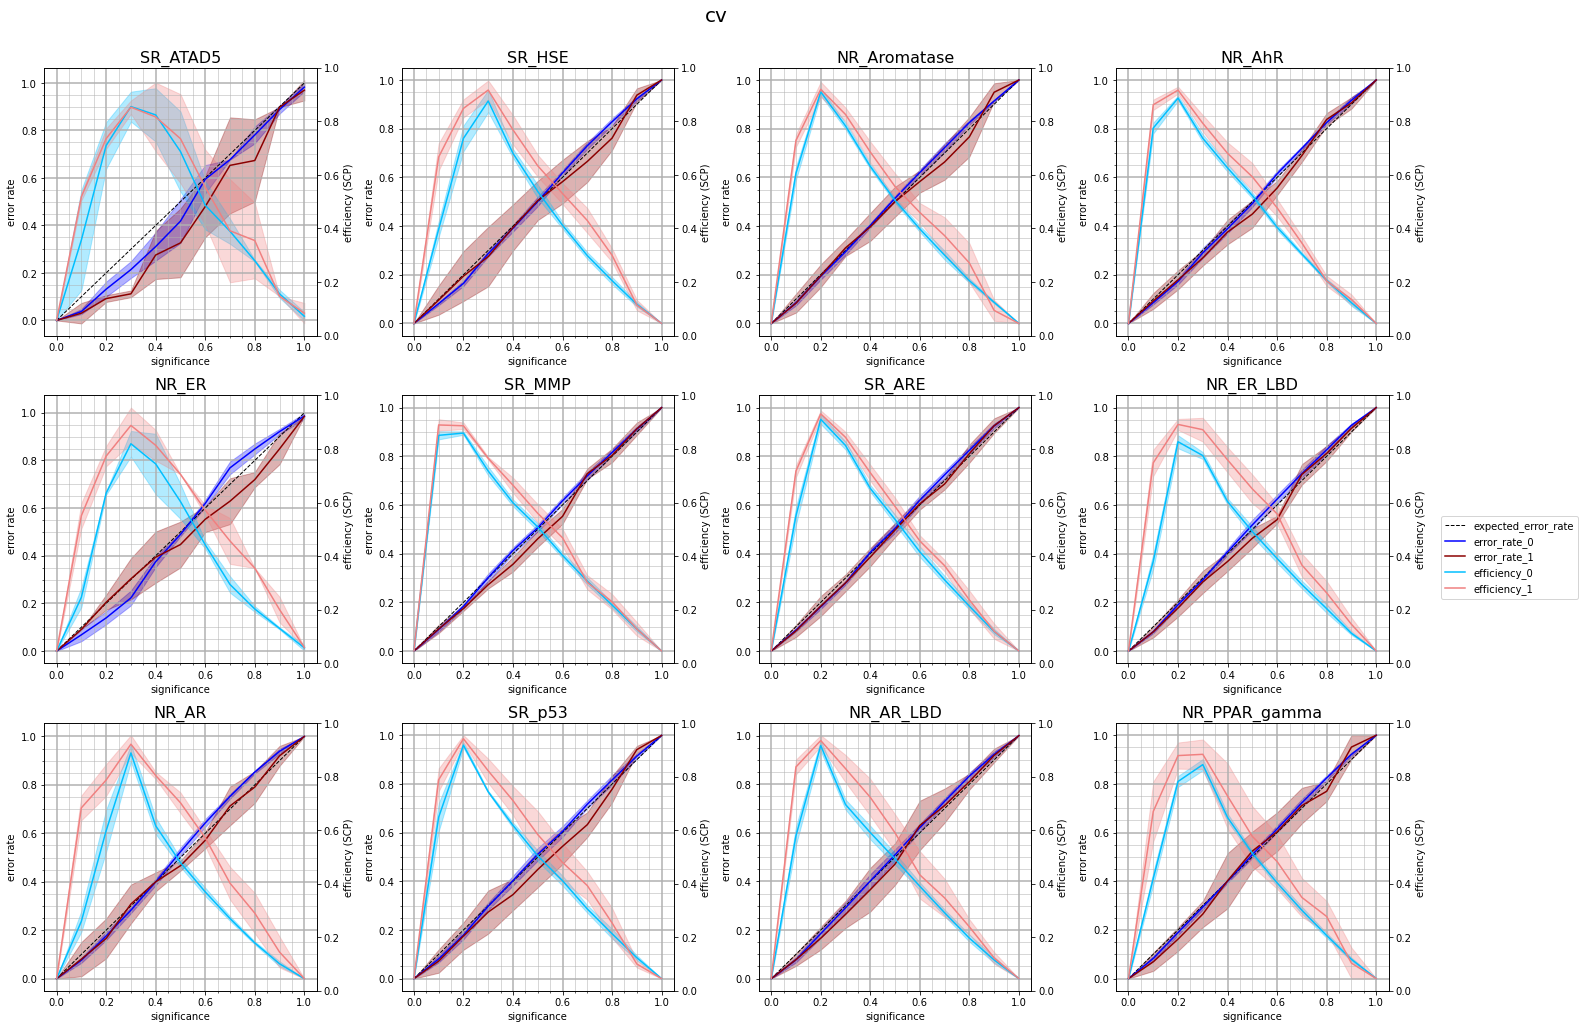

In [14]:
draw_calibration_plot_all_endpoints(endpoints=endpoints, strategy='cv', path=data_statistics_path)

### 3.2. rmsd's
#### Calculate rmsd's for all endpoints over all strategies

To have a value to compare the calibration plots (validity) over all experiments, we calculate the rmsd of the observed error rate to the expected error rate (for 10 significance levels). If we accept overconservative validity, we can also calculate rmsd<sub>pos</sub> (todo: change term/name?), only considering the deviation where the observed error rate is higher than the expected error rate.

In [15]:
rmsds = {}
for k, v in evaluation_dfs.items():
    rmsds[k] = []
    for df in v:
        
        rmsd = calculate_rmsd_from_df(df)
        rmsds[k].append(rmsd)

pd.DataFrame(rmsds, index=endpoints)

,cv,pred_score,cal_update,cal_update2,cv_train_update,pred_score_train_update
SR_ATAD5,0.063,0.202,0.023,0.009,0.045,0.086
NR_ER,0.027,0.117,0.037,0.013,0.036,0.061
NR_AR,0.030,0.041,0.064,0.027,0.028,0.033
SR_HSE,0.019,0.045,0.058,0.015,0.022,0.037
SR_MMP,0.011,0.034,0.043,0.013,0.013,0.023
SR_p53,0.012,0.069,0.067,0.025,0.015,0.058
NR_Aromatase,0.013,0.029,0.042,0.023,0.012,0.027
SR_ARE,0.016,0.079,0.036,0.015,0.017,0.067
NR_AR_LBD,0.018,0.039,0.061,0.019,0.018,0.033
NR_AhR,0.015,0.069,0.064,0.022,0.018,0.060


#### Calculate rmsd<sub>pos</sub> 's for all endpoints over all strategies

In [16]:
rmsds_pos = {}
for k, v in evaluation_dfs.items():
    rmsds_pos[k] = []
    for df in v:
        rmsd_pos = calculate_rmsd_pos_from_df(df)
        rmsds_pos[k].append(rmsd_pos)
pd.DataFrame(rmsds_pos, index=endpoints)

,cv,pred_score,cal_update,cal_update2,cv_train_update,pred_score_train_update
SR_ATAD5,0.000,0.202,0.005,0.003,0.000,0.086
NR_ER,0.011,0.115,0.033,0.005,0.000,0.054
NR_AR,0.028,0.041,0.004,0.020,0.025,0.032
SR_HSE,0.014,0.045,0.052,0.015,0.017,0.037
SR_MMP,0.009,0.034,0.022,0.003,0.009,0.023
SR_p53,0.008,0.069,0.000,0.025,0.008,0.058
NR_Aromatase,0.012,0.029,0.027,0.023,0.010,0.027
SR_ARE,0.013,0.079,0.026,0.011,0.013,0.067
NR_AR_LBD,0.016,0.039,0.000,0.018,0.014,0.033
NR_AhR,0.011,0.069,0.009,0.020,0.011,0.060


### 3.3. Boxplots

Given the rmsd's per endpoint, we can draw a boxplot over the rmsd values for all endpoints. This gives us a nice overview on how the rmsd's change among the different CP set-ups.

In [17]:
strategies = ["cv", 
              "pred_score",
#               "pred_score_scp",  # Uncomment, if SCP data are available
              "pred_score_train_update",
              "cal_update", 
              "cal_update2"]

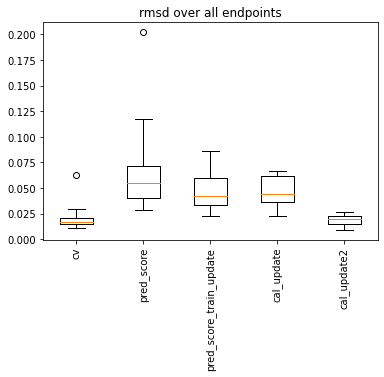

In [18]:
boxplot_rmsd(rmsds, "rmsd", strategies)

todo: more description here, 
1) on what we see, and 
2) on why we also consider rmsd pos. 

Description/discussion will be added here, once the statements of the paper are clear.

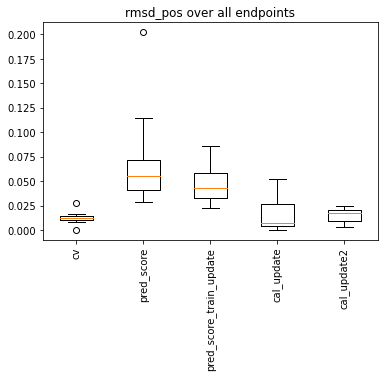

In [19]:
boxplot_rmsd(rmsds_pos, "rmsd_pos", strategies)

### 3.4. Line plots
To see how the rmsds change for the individual endpoints and detect possible "outlier endpoints", we can look at the following line plots.

Note, that these plots were initially used for internal investigation, e.g. which endpoints should be selected as example in the manuscript. If unnecessary, the plots can be deleted from this SI notebook.

In [20]:
def line_plot_rmsd(rmsds, strategies, colours=None, markers=None, figsize=(5, 10)):
    plt.clf()
    fig = plt.figure(figsize=figsize)
    if colours is None:
        colours = ['navy', 'royalblue', 'blueviolet', 'plum', 'mediumvioletred', 'red', 'coral', 'gold', 'yellowgreen', 'green', 'paleturquoise', 'slategrey']
    if markers is None:
        markers = ['3', '<', '>', 'x', 's', '+', 'd', 'h', '*', '1', 'o', 'D']
    for i, ep in enumerate(endpoints):
    
        plt.plot(strategies, [rmsds[s][i] for s in strategies], color=colours[i], linewidth=0.5)#, marker='-o')
        plt.scatter(strategies, [rmsds[s][i] for s in strategies], label=ep, color=colours[i], marker=markers[i], s=50)
        plt.xticks(rotation='vertical')
        plt.legend(endpoints, loc='upper right', bbox_to_anchor=(1.5, 1))
    

<Figure size 432x288 with 0 Axes>

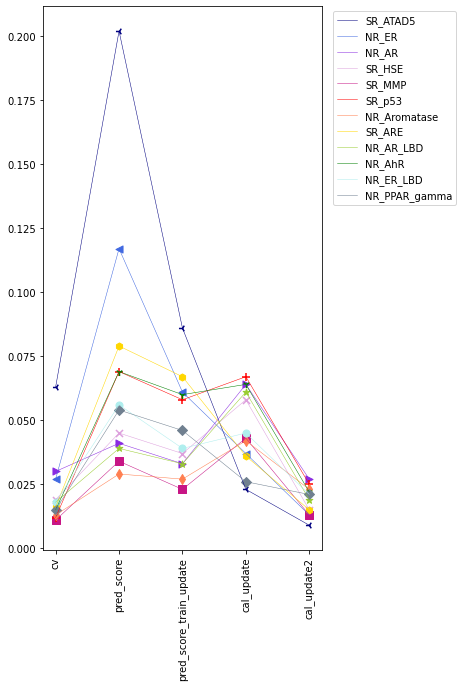

In [21]:
line_plot_rmsd(rmsds, strategies)

<Figure size 432x288 with 0 Axes>

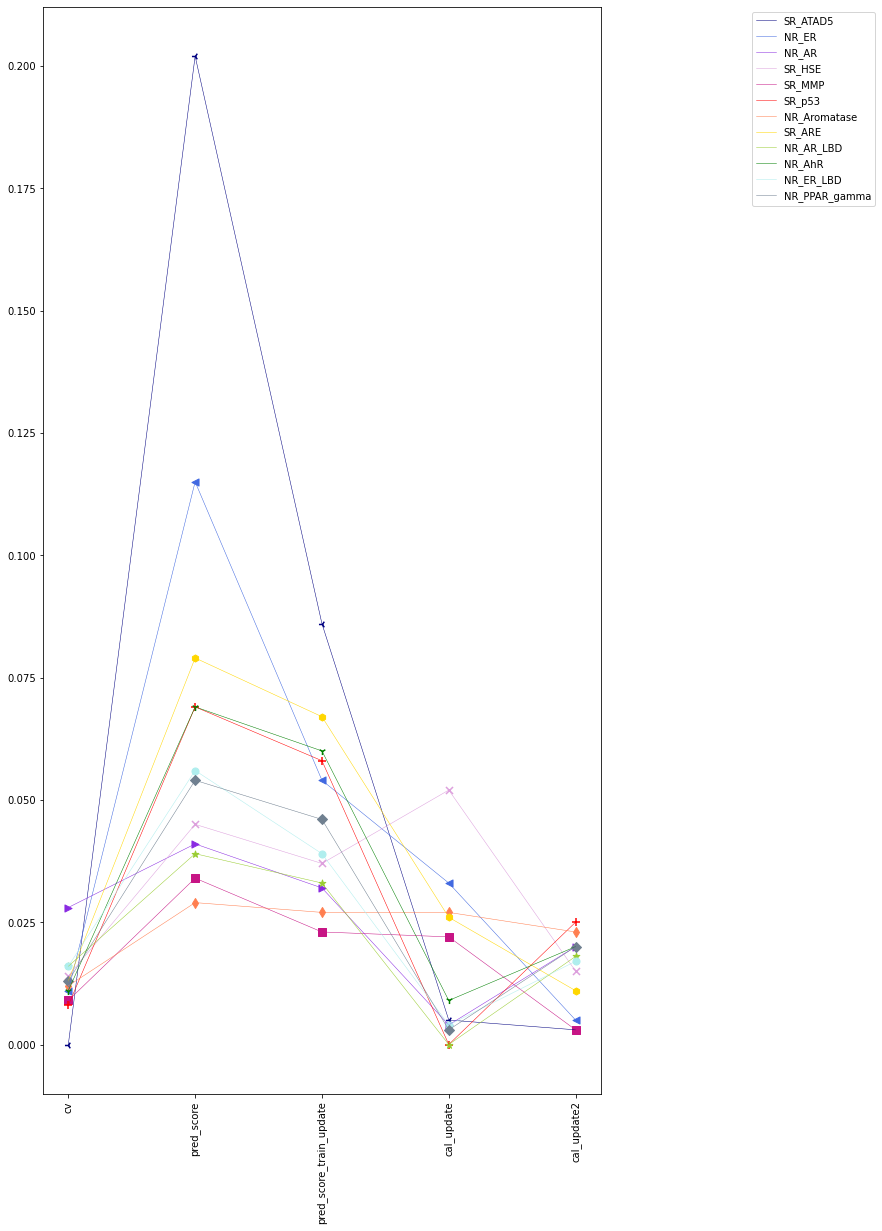

In [22]:
line_plot_rmsd(rmsds_pos, strategies, figsize=(10, 20))